# Kernel Density Estimation

[Book](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)

[Colab](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')

## Kernel Density Estimation in Practice

The free parameters of kernel density estimation are the *kernel*, which specifies the shape of the distribution placed at each point, and the *kernel bandwidth*, which controls the size of the kernel at each point.
In practice, there are many kernels you might use for kernel density estimation: in particular, the Scikit-Learn KDE implementation supports six kernels, which you can read about in the ["Density Estimation" section](http://scikit-learn.org/stable/modules/density.html) of the documentation.

While there are several versions of KDE implemented in Python (notably in the SciPy and `statsmodels` packages), I prefer to use Scikit-Learn's version because of its efficiency and flexibility.
It is implemented in the `sklearn.neighbors.KernelDensity` estimator, which handles KDE in multiple dimensions with one of six kernels and one of a couple dozen distance metrics.
Because KDE can be fairly computationally intensive, the Scikit-Learn estimator uses a tree-based algorithm under the hood and can trade off computation time for accuracy using the `atol` (absolute tolerance) and `rtol` (relative tolerance) parameters.
The kernel bandwidth can be determined using Scikit-Learn's standard cross-validation tools, as we will soon see.

Let's first show a simple example of replicating the previous plot using the Scikit-Learn `KernelDensity` estimator (see the following figure):

## Motivating Kernel Density Estimation: Histograms

As mentioned previously, a density estimator is an algorithm that seeks to model the probability distribution that generated a dataset.
For one-dimensional data, you are probably already familiar with one simple density estimator: the histogram.
A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

For example, let's create some data that is drawn from two normal distributions:

In [6]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

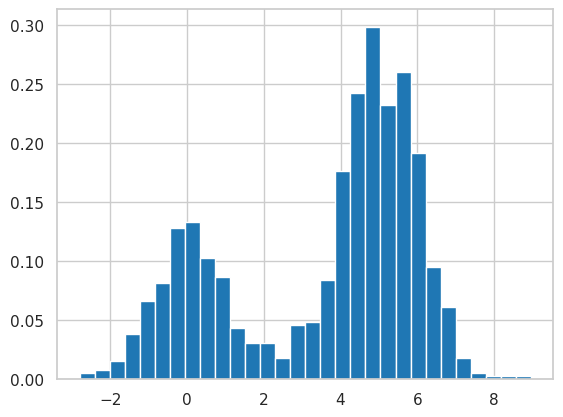

In [7]:
hist = plt.hist(x, bins=30, density=True)

In [8]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

In [9]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

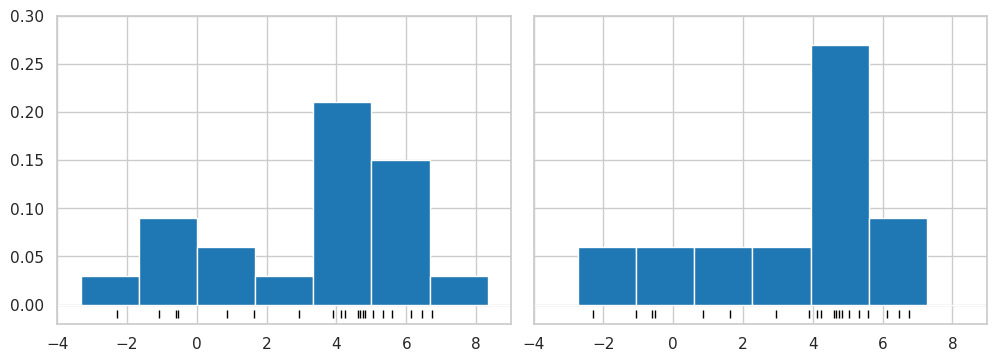

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

(-0.2, 8.0)

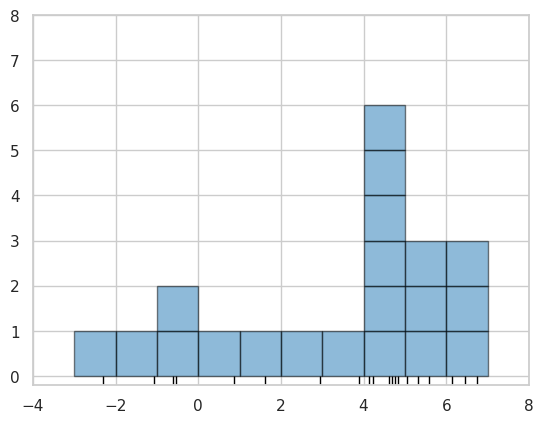

In [11]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle(
            (edge, i), 1, 1, ec='black', alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

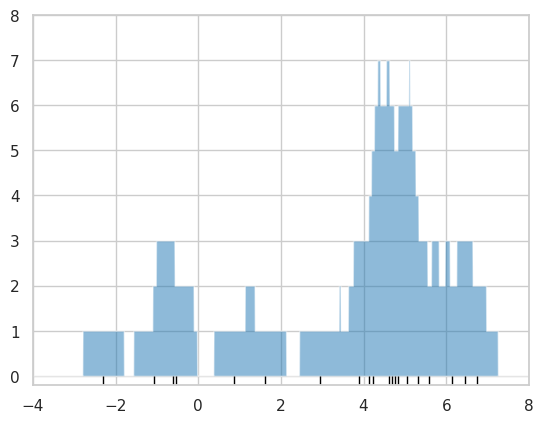

In [12]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

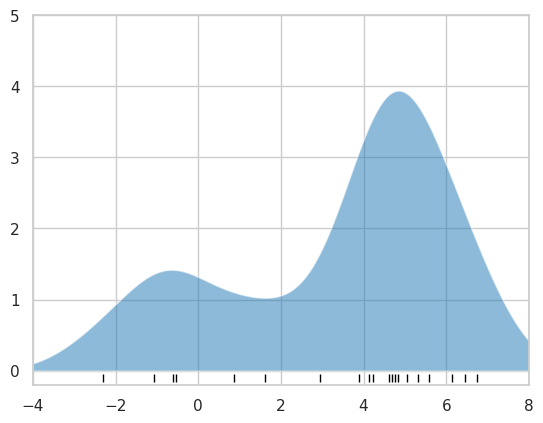

In [13]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

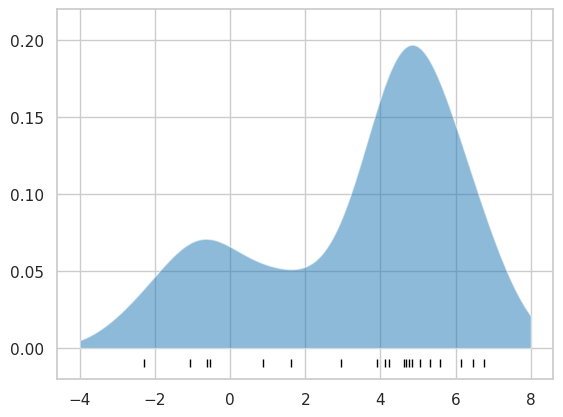

In [15]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22);

## Selecting the Bandwidth via Cross-Validation

The final estimate produced by a KDE procedure can be quite sensitive to the choice of bandwidth, which is the knob that controls the bias–variance trade-off in the estimate of density.
Too narrow a bandwidth leads to a high-variance estimate (i.e., overfitting), where the presence or absence of a single point makes a large difference. Too wide a bandwidth leads to a high-bias estimate (i.e., underfitting), where the structure in the data is washed out by the wide kernel.

There is a long history in statistics of methods to quickly estimate the best bandwidth based on rather stringent assumptions about the data: if you look up the KDE implementations in the SciPy and `statsmodels` packages, for example, you will see implementations based on some of these rules.

In machine learning contexts, we've seen that such hyperparameter tuning often is done empirically via a cross-validation approach.
With this in mind, Scikit-Learn's `KernelDensity` estimator is designed such that it can be used directly within the package's standard grid search tools.
Here we will use `GridSearchCV` to optimize the bandwidth for the preceding dataset.
Because we are looking at such a small dataset, we will use leave-one-out cross-validation, which minimizes the reduction in training set size for each cross-validation trial:

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

In [18]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

## Example: Not-so-Naive Bayes

This example looks at Bayesian generative classification with KDE, and demonstrates how to use the Scikit-Learn architecture to create a custom estimator.

In [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) we explored naive Bayesian classification, in which we create a simple generative model for each class, and use these models to build a fast classifier.
For Gaussian naive Bayes, the generative model is a simple axis-aligned Gaussian.
With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class.
It's still Bayesian classification, but it's no longer naive.

The general approach for generative classification is this:

1. Split the training data by label.

2. For each set, fit a KDE to obtain a generative model of the data.
   This allows you, for any observation $x$ and label $y$, to compute a likelihood $P(x~|~y)$.
   
3. From the number of examples of each class in the training set, compute the *class prior*, $P(y)$.

4. For an unknown point $x$, the posterior probability for each class is $P(y~|~x) \propto P(x~|~y)P(y)$.
   The class that maximizes this posterior is the label assigned to the point.

The algorithm is straightforward and intuitive to understand; the more difficult piece is couching it within the Scikit-Learn framework in order to make use of the grid search and cross-validation architecture.

This is the code that implements the algorithm within the Scikit-Learn framework; we will step through it following the code block:

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(axis=1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### Using Our Custom Estimator

Let's try this custom estimator on a problem we have seen before: the classification of handwritten digits.
Here we will load the digits and compute the cross-validation score for a range of candidate bandwidths using the ``GridSearchCV`` meta-estimator (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)):

In [20]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

grid = GridSearchCV(KDEClassifier(), {'bandwidth': np.logspace(0, 2, 100)})

grid.fit(digits.data, digits.target);

best param: {'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


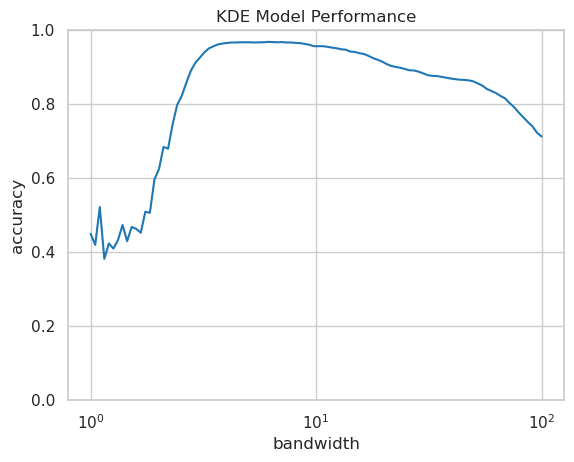

In [21]:
fig, ax = plt.subplots()
ax.semilogx(np.array(grid.cv_results_['param_bandwidth']),
            grid.cv_results_['mean_test_score'])
ax.set(title='KDE Model Performance', ylim=(0, 1),
       xlabel='bandwidth', ylabel='accuracy')
print(f'best param: {grid.best_params_}')
print(f'accuracy = {grid.best_score_}')

This indicates that our KDE classifier reaches a cross-validation accuracy of over 96%, compared to around 80% for the naive Bayes classifier:

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.8069281956050759